In [176]:


import pandas as pd
import geopandas as gpd
import xgboost
from sklearn.preprocessing import LabelEncoder
import numpy as np
from math import * 
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import DBSCAN, OPTICS

import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 250
plt.style.use('dark_background')

from utils import plot_cluster, load_list, save_list

In [79]:
train_df_origin = gpd.read_file("train.geojson", index_col=0)
test_df_origin = gpd.read_file("test.geojson", index_col=0)

In [3]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

In [400]:
train_df['area'].head()

0    1.237159e-06
1    4.701495e-07
2    4.536881e-07
3    2.936349e-07
4    2.905206e-07
Name: area, dtype: float64

In [282]:
def xy(i, df):
    '''Give positions of centroid of i-th data in a df containing geometry feature
    output: x, y (positions)
    '''
    c = df.iloc[i].geometry.centroid
    return c.x, c.y

In [327]:
def consecutive_points_d(df):
    '''Returns a list of distances between two consecutive data of df, a dataframe containing feature geometry.
    '''
    n_data = len(df)
    L = list()
    for i in tqdm(range(0, n_data - 1)):
        x1, y1 = xy(i, df)
        x2, y2 = xy(i+1, df)
        squared_distance = sqrt((x1-x2)**2 + (y1-y2)**2)
        L.append(squared_distance)
    return L

distances = consecutive_points_d(train_df_origin[:9999999999])

In [394]:

save_list(distances, name = 'distances_train.npy')
distances = load_list('distances_train.npy')

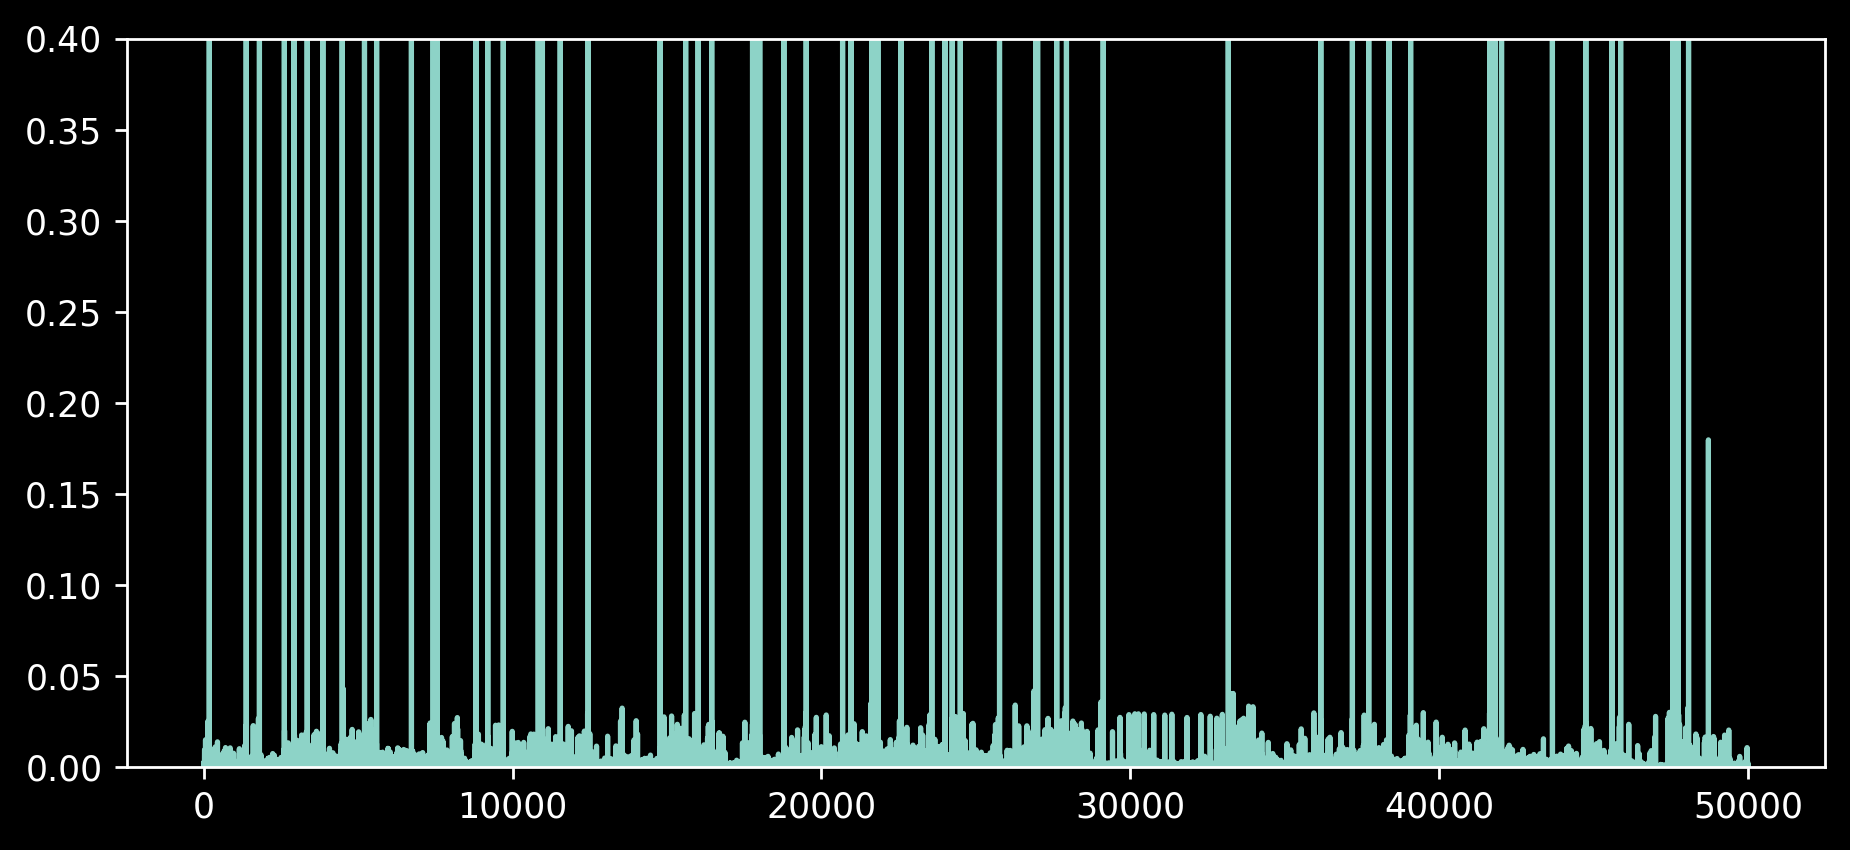

In [333]:
plt.ylim(top = .4)
plt.plot(distances[0:50000])
#According to the plot, we need to chose the critic distance (for classifying a change of data as a change of clusters)
#around 0.05

Lowest big variation: 0.030013511385862984
Happened between indices 261131 and 261132


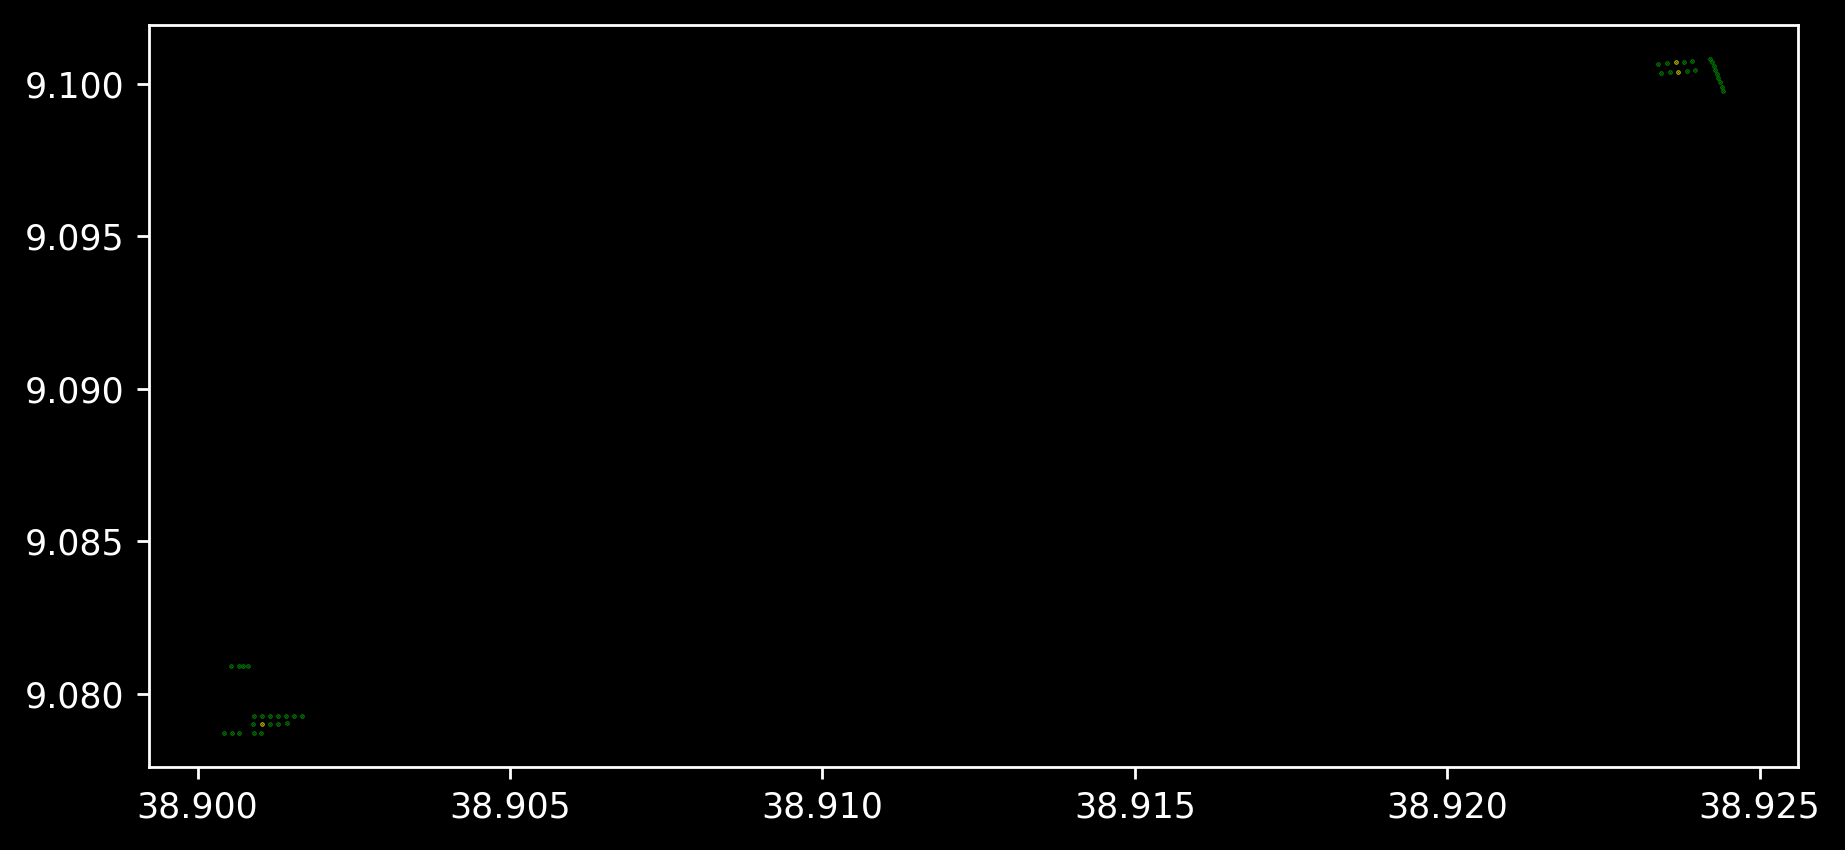

In [385]:
eps = 0.03      #Value sufficient for change of data to be considered as a change of cluster
indices_huge_variations = [i for i, distance in enumerate(distances) if distance > eps]     #i(var)
huge_variations = np.array([distances[i] for i in indices_huge_variations])                 #valeur(var)
n_minimal_huge_variation = np.argmin(huge_variations)                                       
n_nearest_but_different_cluster = indices_huge_variations[n_minimal_huge_variation]         #i(min_var)

print("Lowest big variation:", np.min(huge_variations))
print(f"Happened between indices {n_nearest_but_different_cluster} and {n_nearest_but_different_cluster+1}")
two_clusters = train_df_origin[n_nearest_but_different_cluster - 20: n_nearest_but_different_cluster + 20]
plot_cluster(two_clusters)

#We choose the lowest eps possible with the constraint that the lowest "big" variation did not lead to divide a cluster
#but truly to create 2 clusters. In the train case, it is 0.03

176 1371


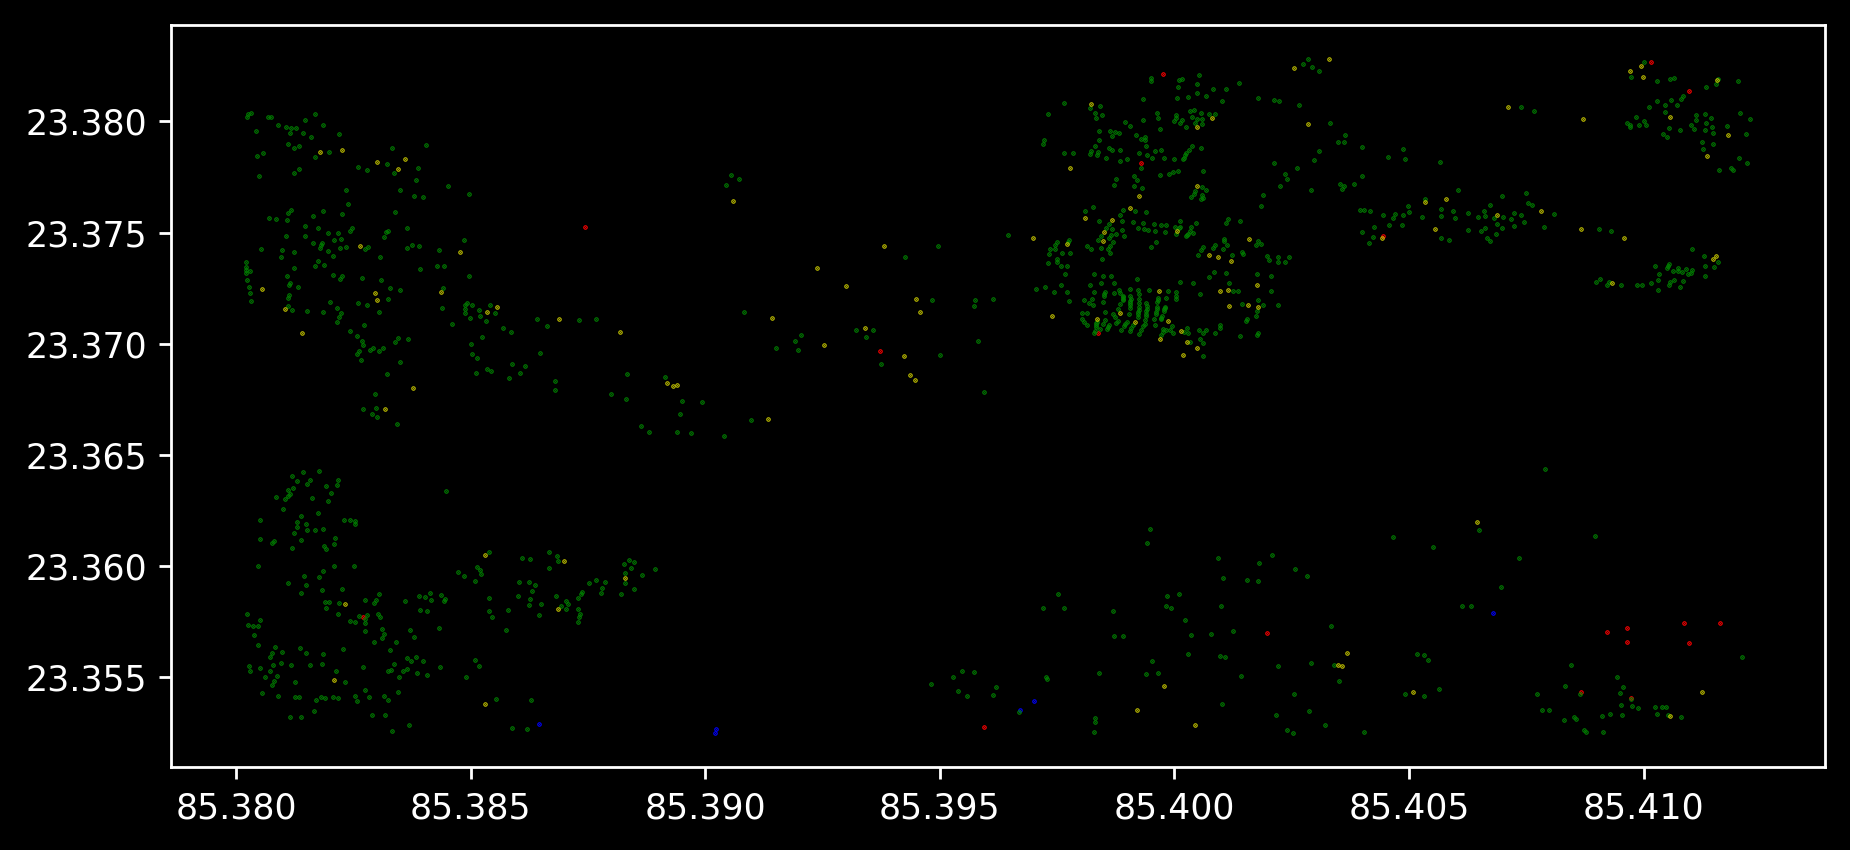

,index,change_type,change_status_date1,change_status_date2,change_status_date3,change_status_date4,change_status_date5,date1,date2,date3,date4,date5,urban_types,geography_types,geometry
176,176,Residential,Land Cleared,Land Cleared,Construction Done,Construction Done,Construction Done,09-05-2015,06-11-2016,19-11-2017,25-10-2018,01-12-2019,Sparse Urban,"Sparse Forest,Grass Land,Lakes","POLYGON ((85.38067 23.38028, 85.38063 23.38015..."
177,177,Residential,Land Cleared,Construction Done,Construction Done,Construction Done,Construction Done,09-05-2015,06-11-2016,19-11-2017,25-10-2018,01-12-2019,Sparse Urban,"Sparse Forest,Grass Land,Lakes","POLYGON ((85.38073 23.38026, 85.38068 23.38015..."
178,178,Residential,Greenland,Greenland,Greenland,Greenland,Construction Midway,09-05-2015,06-11-2016,19-11-2017,25-10-2018,01-12-2019,Sparse Urban,"Sparse Forest,Grass Land,Lakes","POLYGON ((85.38019 23.38040, 85.38032 23.38036..."
179,179,Residential,Greenland,Land Cleared,Greenland,Greenland,Excavation,09-05-2015,06-11-2016,19-11-2017,25-10-2018,01-12-2019,Sparse Urban,"Sparse Forest,Grass Land,Lakes","POLYGON ((85.38028 23.38038, 85.38033 23.38037..."
180,180,Residential,Greenland,Greenland,Land Cleared,Construction Midway,Construction Midway,09-05-2015,06-11-2016,19-11-2017,25-10-2018,01-12-2019,Sparse Urban,"Sparse Forest,Grass Land,Lakes","POLYGON ((85.38020 23.38027, 85.38029 23.38025..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,1367,Commercial,Prior Construction,Prior Construction,Prior Construction,Prior Construction,Prior Construction,09-05-2015,06-11-2016,19-11-2017,25-10-2018,01-12-2019,Sparse Urban,"Sparse Forest,Farms","POLYGON ((85.39362 23.37447, 85.39362 23.37427..."
1368,1368,Commercial,Prior Construction,Prior Construction,Prior Construction,Prior Construction,Prior Construction,09-05-2015,06-11-2016,19-11-2017,25-10-2018,01-12-2019,Sparse Urban,"Sparse Forest,Dense Forest,Farms","POLYGON ((85.39439 23.37163, 85.39449 23.37120..."
1369,1369,Residential,Land Cleared,Land Cleared,Construction Done,Construction Done,Construction Done,09-05-2015,06-11-2016,19-11-2017,25-10-2018,01-12-2019,None,"River,Sparse Forest,Dense Forest,Farms","POLYGON ((85.40289 23.37700, 85.40285 23.37686..."
1370,1370,Residential,Prior Construction,Prior Construction,Prior Construction,Prior Construction,Prior Construction,09-05-2015,06-11-2016,19-11-2017,25-10-2018,01-12-2019,Dense Urban,"Sparse Forest,Grass Land,Lakes","POLYGON ((85.40361 23.37946, 85.40358 23.37935..."


In [397]:
def get_variations(distances, eps):
    '''From a list of distances, give indexes where the change exceed eps.
    distances : list (of distances)
    eps : treshold for a variation to be considered as a change of cluster
    '''
    return [i for i, distance in enumerate(distances) if distance > eps]

def index2cluster(i, variations, df):
    '''Associate the i-th data with a cluster
    i: index of a data
    variations : a list of indexes where variations (change of clusters) happened. Obtained through get_variations function.
    df : a dataframe containing geometry feature.
    output: a dataframe containing ony data of the same cluster as i.
    '''
    variations = [-1] + variations + [len(df)]
    Ni = 0
    for j in range(len(variations) - 1):
        Nf = variations[j+1]
        if Ni <= i <= Nf:
            print(Ni, Nf)
            return df[Ni:Nf+1]
        Ni = Nf + 1

variations = get_variations(distances, eps = 0.03)
N = 222
cluster_of_222 = index2cluster(N, variations, train_df_origin)
plot_cluster(cluster_of_222)
cluster_of_222

In [268]:
#Other method : Clustering with scikit learn
x, y = train_df_origin['geometry'].apply(lambda x : x.centroid.x), train_df_origin['geometry'].apply(lambda x : x.centroid.y)
data = pd.concat([x, y], axis=1)

In [387]:
n_data_max = 50000
my_df = train_df_origin[:n_data_max]
cl = DBSCAN(eps = 0.05).fit_predict(data[:n_data_max])
np.unique(cl).shape

(59,)

In [ ]:
#Save/plot figures of each cluster
for label in range(np.unique(cl).shape[0]):
    cluster = my_df[cl == label]
    plt.clf()
    plot_cluster(cluster)
    #plot_cluster(cluster, save = f"figures/cluster_{label}")